In [30]:
from utils import *
from functools import reduce
import polars as pl
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict
from collections import Counter
from collections import defaultdict
from typing import Dict, Any
import gower
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read the csv files of the transactions
file_path_transactions = "../data/processed/transactions.parquet"
pd_transactions = pl.read_parquet(file_path_transactions)
# Read the csv files of the baskets
file_path_baskets = "../data/processed/baskets.parquet"
baskets = pl.read_parquet(file_path_baskets)
# Read the csv files of the temporal metrics of the transactions
file_path_temporal_metrics = "../data/processed/temporal_metrics.parquet"
temporal_metrics = pl.read_parquet(file_path_temporal_metrics)
# Read the csv files of the atributes
file_path_atributes = "../data/processed/atributes.parquet"
pd_atributes = pl.read_parquet(file_path_atributes)
pd_atributes['poc'] = pd_atributes['poc'].astype(str)
pd_atributes.head()

,column_0,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,segmentounico,canal
0,10,175519,HighUsage,5.18752,4.1000,16,Medio,4.Activos,Kioscos/Maxikioscos
1,13,28533,HighUsage,4.76866,3.9211,34,Alto,4.Activos,Tradicional
2,19,32182,PowerUsage,5.97930,6.7500,34,Alto,4.Activos,Tradicional
3,20,327976,MinimalUsage,6.02852,3.5833,14,Alto,4.Activos,COMIDA
4,24,354640,PowerUsage,7.52500,3.2000,18,Bajo,4.Activos,Tradicional


## Aply Gower distance and hierarchical clustering to segment the users

Gower Distance: This distance metric is ideal for datasets with mixed types (numerical, categorical ordinal, and categorical nominal).

Hierarchical Clustering: We use the linkage function with the 'average' method to perform agglomerative clustering.

Dendrogram: The dendrogram helps visualize the clustering process and decide where to cut the tree to form clusters.

Cluster Assignment: We use fcluster to assign cluster labels based on the dendrogram.

In [3]:
# Compute Gower distance matrix
gower_dist = gower.gower_matrix(pd_atributes)

/var/folders/02/wzc8k1dn7bsgd14yfq9md5l40000gn/T/ipykernel_2949/144325031.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


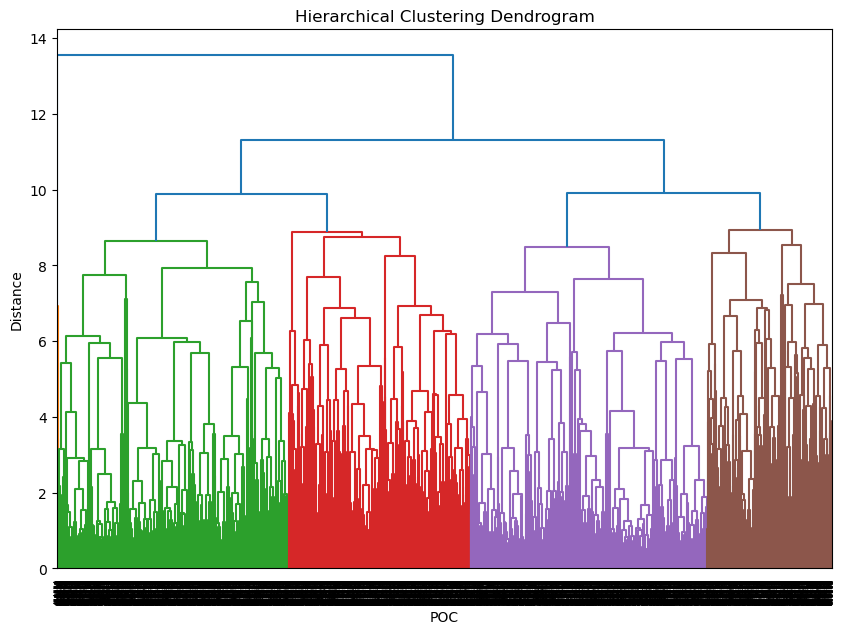

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the Gower distance matrix
Z = linkage(gower_dist, method='average')

# Plot the dendrogram to visualize the clusters
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=pd_atributes['poc'].values)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("POC")
plt.ylabel("Distance")
plt.show()

In [5]:
num_clusters = 6
clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
pd_atributes['cluster'] = clusters
pd_atributes.groupby(by=clusters).count()['poc']

1       5
2    1313
3    1031
4    1343
5     417
6     291
Name: poc, dtype: int64

In [6]:
# Group by the clusters to understand their characteristics
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
pd_atributes.groupby('cluster')[numerical].describe().T

cluster                                      1            2            3  \
totalvolumen                count     5.000000  1313.000000  1031.000000   
                            mean    920.381354    15.442391    24.081094   
                            std    1875.761121    66.571897    83.172525   
                            min      13.441700     0.054920     0.021240   
                            25%      56.252500     2.091260     1.987300   
                            50%      97.355290     5.268540     6.414940   
                            75%     160.413120    11.788420    18.994970   
                            max    4274.444160  1281.067160  1691.436000   
skudistintospromediosxorden count     5.000000  1313.000000  1031.000000   
                            mean      7.869040     6.474492     6.504067   
                            std       4.073639     3.517596     3.376117   
                            min       2.343600     0.750000     0.702700   
                            25%       4.809500     4.000000     4.000000   
                            50%       9.608700     5.750000     5.764700   
                            75%      11.166700     8.111100     8.142900   
                            max      11.416700    33.000000    27.428600   
skudistintostotales         count     5.000000  1313.000000  1031.000000   
                            mean     91.000000    31.926123    28.736178   
                            std      50.438081    23.144987    23.298240   
                            min      32.000000     1.000000     1.000000   
                            25%      68.000000    14.000000    11.000000   
                            50%      70.000000    26.000000    22.000000   
                            75%     128.000000    44.000000    40.000000   
                            max     157.000000   150.000000   126.000000   

cluster                                      4            5            6  
totalvolumen                count  1343.000000   417.000000   291.000000  
                            mean     18.181856    36.564326    29.650284  
                            std      79.536553   109.588173   135.287429  
                            min       0.025080     0.062060     0.045000  
                            25%       2.097970     5.262060     1.142080  
                            50%       4.934000    13.137060     3.301280  
                            75%      10.292390    28.713640     7.449120  
                            max    1322.642780  1623.862640  1665.981700  
skudistintospromediosxorden count  1343.000000   417.000000   291.000000  
                            mean      5.041289     6.068862     5.021730  
                            std       2.492491     3.478607     2.850529  
                            min       0.750000     0.750000     0.750000  
                            25%       3.292850     3.636400     3.000000  
                            50%       4.500000     5.216200     4.142900  
                            75%       6.191400     7.375000     6.112500  
                            max      21.000000    24.125000    17.333300  
skudistintostotales         count  1343.000000   417.000000   291.000000  
                            mean     23.651526    33.599520    16.109966  
                            std      17.376366    21.765916    15.034957  
                            min       1.000000     3.000000     1.000000  
                            25%      11.000000    17.000000     7.000000  
                            50%      19.000000    27.000000    11.000000  
                            75%      31.000000    46.000000    19.000000  
                            max     123.000000   113.000000   129.000000

In [18]:
pd_transactions_cluster = pd_transactions.merge(pd_atributes[['poc', 'cluster']], how='left', left_on='account_id', right_on='poc')
print(100* (pd_transactions_cluster.poc.isnull().sum()/pd_transactions.shape[0]))
pd_transactions_cluster.isnull().sum()

0.7235745723360918


                       0
account_id             0
sku_id                 0
invoice_date           0
order_id               0
items_phys_cases       0
poc                 2032
cluster             2032
dtype: int64

In [19]:
pd_transactions_cluster.dropna(inplace=True)
print(pd_transactions_cluster.shape)
pd_transactions_cluster.isnull().sum()

(278796, 8)


                    0
account_id          0
sku_id              0
invoice_date        0
order_id            0
items_phys_cases    0
poc                 0
cluster             0
dtype: int64

In [27]:


def build_item_user_matrix_by_cluster(df: pd.DataFrame, cluster_col: str = 'cluster', sku_col: str = 'sku_id', user_col: str = 'account_id', qty_col: str = 'items_phys_cases') -> Dict[Any, Dict[str, Dict[str, int]]]:
    """
    Builds an item-user matrix for each cluster, where the rows represent SKUs (items)
    and the columns represent users. The values in the matrix are the total quantities of
    items purchased by each user within each cluster.

    Args:
        df (pd.DataFrame): The DataFrame containing transaction data along with cluster assignments.
        cluster_col (str): The name of the column representing the cluster assignment.
        sku_col (str): The name of the column representing the SKUs (items).
        user_col (str): The name of the column representing the user IDs.
        qty_col (str): The name of the column representing the quantity of items purchased.

    Returns:
        Dict: A dictionary where each key is a cluster ID, and the value is another dictionary
              representing the item-user matrix for that cluster. In the item-user matrix:
              - The keys are SKUs (items).
              - The inner keys are user IDs.
              - The inner values are the total quantities of each SKU purchased by the corresponding user.
    
    Example:
        cluster_item_user_matrices = build_item_user_matrix_by_cluster(pd_transactions_cluster, 
                                                                       cluster_col='cluster',
                                                                       sku_col='sku_id',
                                                                       user_col='account_id',
                                                                       qty_col='items_phys_cases')
    """
    cluster_item_user_matrices = {}

    # Group by clusters
    for cluster_id in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster_id]
        item_user_matrix = defaultdict(lambda: defaultdict(int))
        
        for _, row in cluster_df.iterrows():
            for sku in row[sku_col]:
                item_user_matrix[sku][row[user_col]] += row[qty_col]
        
        cluster_item_user_matrices[cluster_id] = item_user_matrix

    return cluster_item_user_matrices


In [28]:
cluster_item_user_matrices = build_item_user_matrix_by_cluster(pd_transactions_cluster, 
                                                               cluster_col='cluster',
                                                               sku_col='sku_id',
                                                               user_col='account_id',
                                                               qty_col='items_phys_cases')